# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import RandomState
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats as st
from sklearn.metrics import root_mean_squared_error as rmse

### Импорт данных

## Проверка загрузки БД

In [5]:
data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [6]:
data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [7]:
data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


## Подготовка данных

Столбец ID не влияет на финальный результат и необходимо исключить для работы обучающей модели.

In [8]:
data_0 = data_0.drop('id', axis=1)
data_1 = data_1.drop('id', axis=1)
data_2 = data_2.drop('id', axis=1)

## Анализ данных

In [9]:
# слоаврь для построения графиков через цикл
dict = ['f0', 'f1', 'f2', 'product']

### Анализ пропусков

In [10]:
data_0.isna().sum()

f0         0
f1         0
f2         0
product    0
dtype: int64

In [11]:
data_1.isna().sum()

f0         0
f1         0
f2         0
product    0
dtype: int64

In [12]:
data_2.isna().sum()

f0         0
f1         0
f2         0
product    0
dtype: int64

Пропусков в данных нет

### Корреляции данных

In [13]:
data_0.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [14]:
data_1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [15]:
data_2.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


### Выводы по анализу корреляций

В данных geo_1 есть ярко выраженная корреляция между параметром f2 и product (корреляция 99%).

### Граифики для data_0

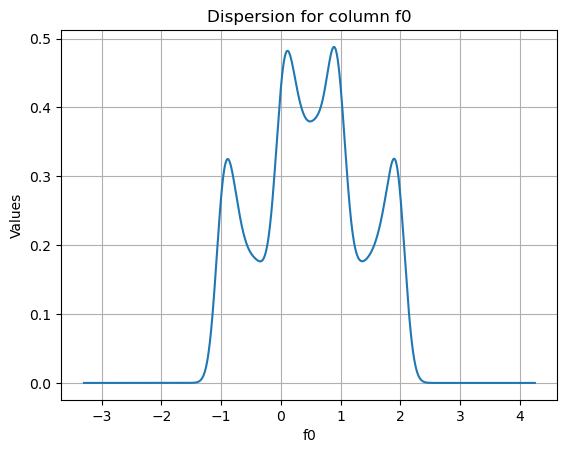

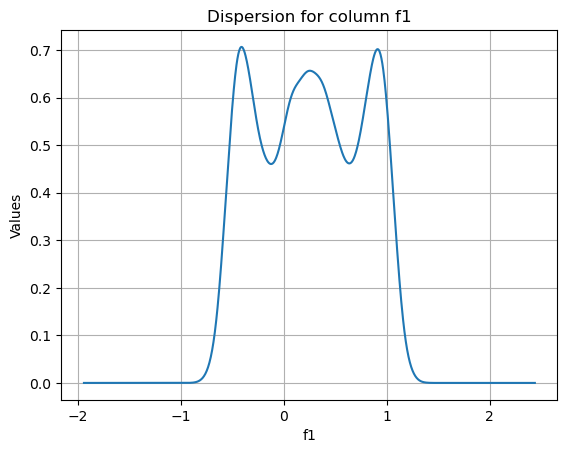

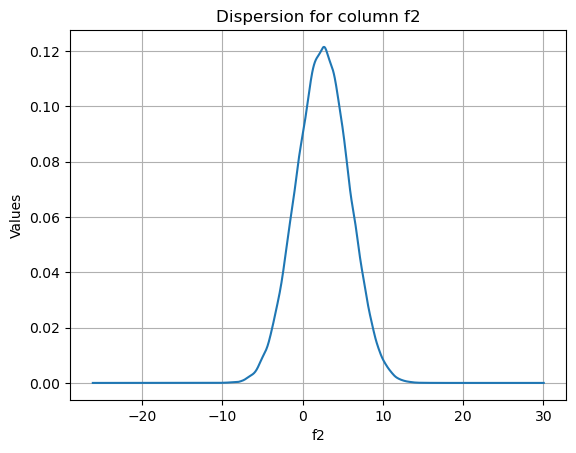

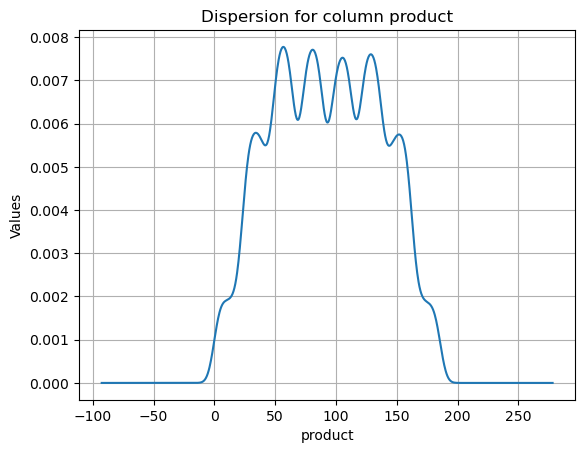

In [16]:
for col in dict:
    data_0[col].plot(kind='density', grid=True)
    plt.title(f'Dispersion for column {col}')
    plt.ylabel('Values')
    plt.xlabel(col)
    plt.show()

### Граифики для data_1

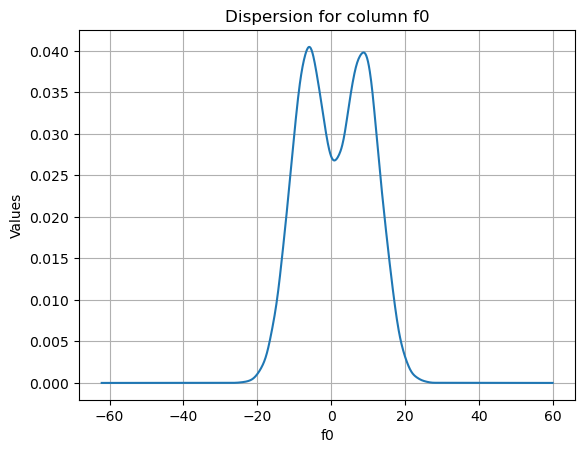

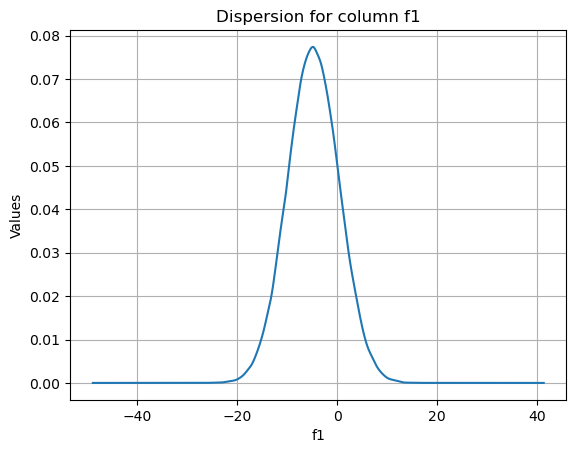

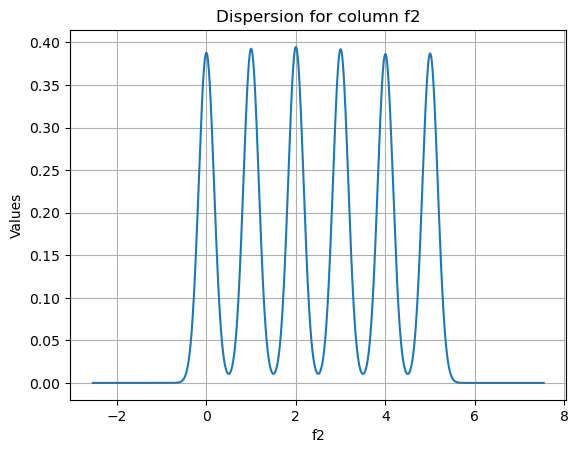

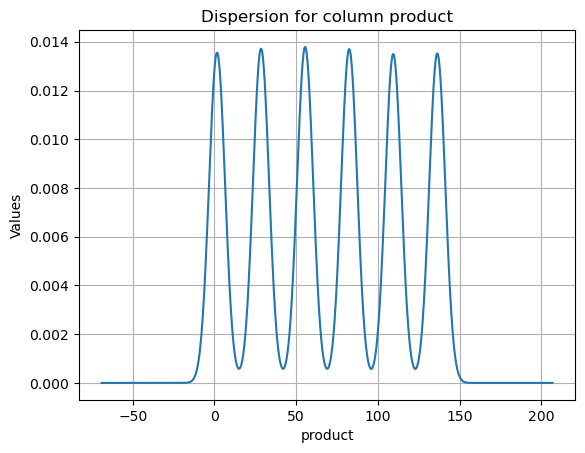

In [17]:
for col in dict:
    data_1[col].plot(kind='density', grid=True)
    plt.title(f'Dispersion for column {col}')
    plt.ylabel('Values')
    plt.xlabel(col)
    plt.show()

### Граифики для data_2

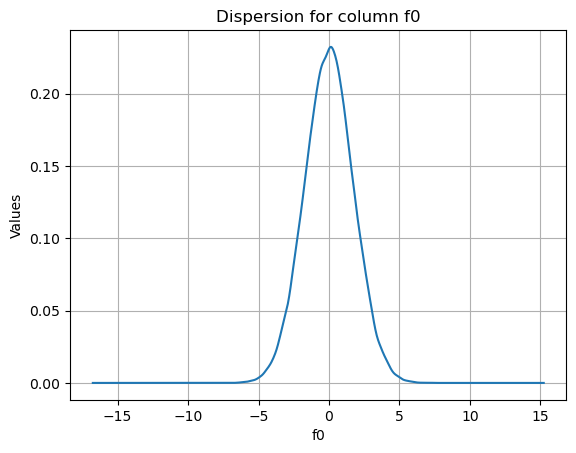

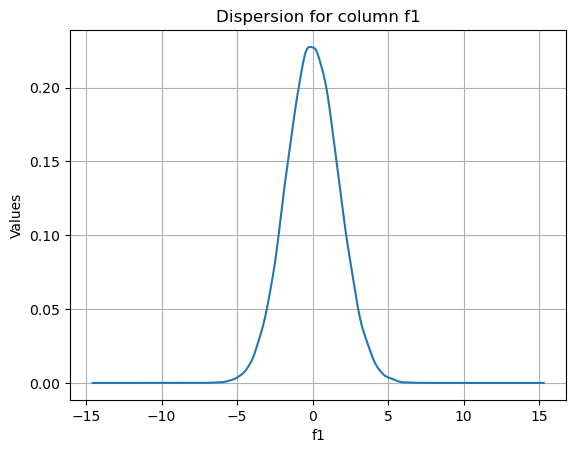

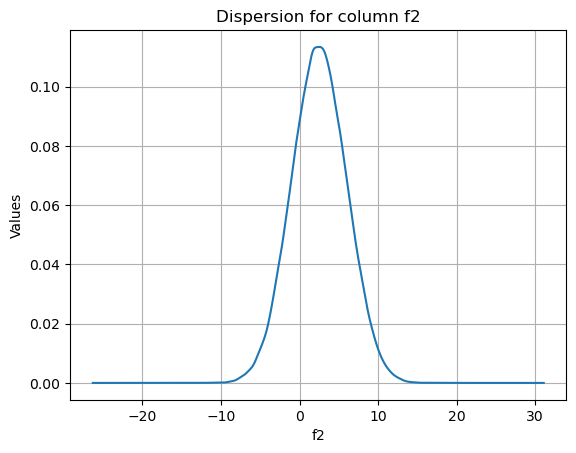

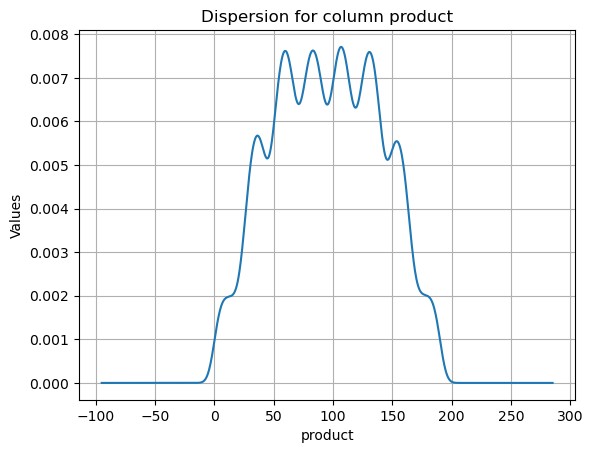

In [18]:
for col in dict:
    data_2[col].plot(kind='density', grid=True)
    plt.title(f'Dispersion for column {col}')
    plt.ylabel('Values')
    plt.xlabel(col)
    plt.show()

## Проверка средних значений

In [19]:
data_0['product'].mean()

92.50000000000001

In [20]:
data_1['product'].mean()

68.82500000000002

In [21]:
data_2['product'].mean()

95.00000000000004

Среднее количество объёма запасов в скважине в последнем датасете(data_2) больше чем в первом и втором.

# Обучение и проверка модели

В данном материале будет использоваться модель обучения "Линейная регрессия".  
Качество Регрессионых моделей оценивается параметром RMSE(среднеквадратичная ошибка)

In [22]:
model = LinearRegression()

## Функция подготовки данных

При выполнении поставленной задачи необходимо работать с 3 разными датасетами, целесообразно создать функцию по подготовке данных, что бы автоматизировать этот процесс.

In [23]:
def data_split(data): # на вход принимает датасет
    features = data.drop('product', axis = 1) # выделение фичей для обучения
    target = data['product'] # выделение таргета для обучения
    train_features, valid_features, train_target, valid_target = train_test_split(
                                                                features, target, test_size=0.25, train_size=0.75, random_state=160891)
    return train_features, valid_features, train_target, valid_target # возврат данных после разбивки

## Обучение модели для данных geo_0

In [24]:
train_features_0, valid_features_0, train_target_0, valid_target_0 = data_split(data_0)

In [25]:
print(f'Размер тренировочной выборки: {len(train_features_0)} | Размер тестовой выборки: {len(valid_features_0)}')

Размер тренировочной выборки: 75000 | Размер тестовой выборки: 25000


In [26]:
model.fit(train_features_0, train_target_0)

LinearRegression()

In [27]:
predict_0 = model.predict(valid_features_0)

In [28]:
print(f'Среднеквадратичное отклонение обученной модели составило {rmse(valid_target_0, predict_0)}')

Среднеквадратичное отклонение обученной модели составило 37.70037111752797


In [29]:
data_pred_0 = {'target_product' : valid_target_0,
               'predicted_product' : predict_0         
              }
data_frame_0 = pd.DataFrame(data_pred_0, columns = ['target_product', 'predicted_product'])

In [30]:
data_frame_0.head()

,target_product,predicted_product
33020,122.565984,104.619687
86812,91.747117,79.908234
16375,54.749960,89.201588
93657,37.305511,72.038355
20049,51.810806,73.666709


## Обучение модели для данных geo_1

In [31]:
train_features_1, valid_features_1, train_target_1, valid_target_1 = data_split(data_1)

In [32]:
print(f'Размер тренировочной выборки: {len(train_features_1)} | Размер тестовой выборки: {len(valid_features_1)}')

Размер тренировочной выборки: 75000 | Размер тестовой выборки: 25000


In [33]:
model.fit(train_features_1, train_target_1)

LinearRegression()

In [34]:
predict_1 = model.predict(valid_features_1)

In [35]:
data_pred_1 = {'target_product' : valid_target_1,
               'predicted_product' : predict_1         
              }
data_frame_1 = pd.DataFrame(data_pred_1, columns = ['target_product', 'predicted_product'])

In [36]:
data_frame_1.head()

,target_product,predicted_product
33020,84.038886,83.392826
86812,0.000000,0.474639
16375,57.085625,57.829445
93657,107.813044,107.408512
20049,26.953261,27.511257


In [37]:
print(f'Среднеквадратичное отклонение обученной модели составило {rmse(valid_target_1, predict_1)}')

Среднеквадратичное отклонение обученной модели составило 0.8925614601683975


## Обучение модели для данных geo_2

In [38]:
features_2 = data_2.drop('product', axis = 1)
target_2 = data_2['product']

In [39]:
train_features_2, valid_features_2, train_target_2, valid_target_2 = train_test_split(features_2, target_2, test_size=0.25, train_size=0.75)

In [40]:
print(f'Размер тренировочной выборки: {len(train_features_2)} | Размер тестовой выборки: {len(valid_features_2)}')

Размер тренировочной выборки: 75000 | Размер тестовой выборки: 25000


In [41]:
model.fit(train_features_2, train_target_2)

LinearRegression()

In [42]:
predict_2 = model.predict(valid_features_2)

In [43]:
data_pred_2 = {'target_product' : valid_target_2,
               'predicted_product' : predict_2         
              }
data_frame_2 = pd.DataFrame(data_pred_2, columns = ['target_product', 'predicted_product'])

In [44]:
data_frame_2.head()

,target_product,predicted_product
27426,124.649581,88.511455
22225,77.528424,66.066406
54596,86.400652,125.378495
60605,1.840385,69.163719
81849,93.282454,94.519815


In [45]:
rmse(valid_target_2, predict_2)

40.288400295737134

## Выводы по обучению моделей

Среднеквдратичное отклонение модели составило (данные|медианное значение):
- Данные о месторождениях 0 (geo_data_0) - 37.70 | 44.35
- Данные о месторождениях 1 (geo_data_1_v2) - 0.89 | 47.47
- Данные о месторождениях 2 (geo_data_2) - 39.99 | 44.88

# Подготовка к расчёту прибыли

Так как далее будет расчитываться доход с каждой объема данных необходимо создать функцию, так как это просто повторяемый процесс

 При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.  
Бюджет на разработку скважин в регионе — 10 млрд рублей.  
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.  
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.  

In [46]:
BUDGET = 10*(10**9)           # Бюджет 10 млрд. рублей
POINTS = 500                  # Исследование 500 точек
BEST_POINTS = 200             # Выборка 200 лучших
PRICE_PER_BARREL = 450 * 1000 # стоимость 1 барреля

In [47]:
average_profit_per_point = BUDGET / BEST_POINTS
average_barrels_per_point = average_profit_per_point / PRICE_PER_BARREL
average_barrels = BUDGET / PRICE_PER_BARREL

print(f'Средняя прибыль на лучшую точку: {average_profit_per_point/1000:.0f} тыс. рублей')
print(f'Средний объем нефти на точку: {average_barrels_per_point:.0f} тыс. барелей')
print(f'Средний объем нефти на регион {average_barrels:.0f} тыс. барелей')

Средняя прибыль на лучшую точку: 50000 тыс. рублей
Средний объем нефти на точку: 111 тыс. барелей
Средний объем нефти на регион 22222 тыс. барелей


In [48]:
print(f'Средний запас нефти на скважину в регионе 1: {data_0["product"].mean():.3f}')
print(f'Средний запас нефти на скважину в регионе 2: {data_1["product"].mean():.3f}')
print(f'Средний запас нефти на скважину в регионе 3: {data_2["product"].mean():.3f}')

Средний запас нефти на скважину в регионе 1: 92.500
Средний запас нефти на скважину в регионе 2: 68.825
Средний запас нефти на скважину в регионе 3: 95.000


Из данных выше видно, что средний запас в регионах на одну точку (Регион_0 - 92.500|Регион_1 - 68,825|Регион_2 - 95) ниже точки безубыточности в 112 тыс. баррелей.

# Расчёт прибыли и рисков 

## Функция расчета прибыли

In [49]:
def revenue(target, probabilities):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:BEST_POINTS]
    return PRICE_PER_BARREL * selected.sum() - BUDGET

### Прибыль по данным geo_0

In [50]:
print(f"По данным представленным в датасете geo_0 прибыль с 200 лучших точек составит {(revenue(data_frame_0['target_product'], data_frame_0['predicted_product'])) / 1_000_000:.3f}  млн. рублей.")

По данным представленным в датасете geo_0 прибыль с 200 лучших точек составит 3291.613  млн. рублей.


### Прибыль по данным geo_1

In [51]:
print(f"По данным представленным в датасете geo_1 прибыль с 200 лучших точек составит {(revenue(data_frame_1['target_product'], data_frame_1['predicted_product'])) / 1_000_000:.3f}  млн. рублей.")

По данным представленным в датасете geo_1 прибыль с 200 лучших точек составит 2415.087  млн. рублей.


### Прибыль по данным geo_2

In [52]:
print(f"По данным представленным в датасете geo_2 прибыль с 200 лучших точек составит {(revenue(data_frame_2['target_product'], data_frame_2['predicted_product'])) / 1_000_000:.3f}  млн. рублей.")

По данным представленным в датасете geo_2 прибыль с 200 лучших точек составит 2546.746  млн. рублей.


## Расчет прибыли

### Функция бутстрепа для подтвежрдения данных

In [53]:
state = np.random.RandomState(160891)

In [54]:
def revenue_bootstrap(target, predictions):
    values=[]
    lost = 0
    for i in range(1000):
        target_sample = target.sample(replace=True, random_state=state, n=POINTS)
        probs_sample = predictions[target_sample.index]
        profit = revenue(target, probs_sample)
        values.append(profit)
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    average = values.mean()
    risk = (values < 0).mean()
    return average, lower, upper, risk

### Регион 0

In [55]:
average_0, lower_0, upper_0, risk_0 = revenue_bootstrap(data_frame_0['target_product'], data_frame_0['predicted_product'])
print('Данные по первому региону.')
print(f'Средняя прибыль по региону составляет {average_0:.2f} тыс.руб.')
print(f'95% доверительный интервал от {lower_0:.2f} до {upper_0:.2f} тыс.руб.')
print(f'Процент риска {risk_0:.2%}')

Данные по первому региону.
Средняя прибыль по региону составляет 396797976.42 тыс.руб.
95% доверительный интервал от -96610936.08 до 883221838.61 тыс.руб.
Процент риска 6.20%


### Регион 1

In [56]:
average_1, lower_1, upper_1, risk_1 = revenue_bootstrap(data_frame_1['target_product'], data_frame_1['predicted_product'])
print('Данные по второму региону.')
print(f'Средняя прибыль по региону составляет {average_1:.2f} тыс.руб.')
print(f'95% доверительный интервал от {lower_1:.2f} до {upper_1:.2f} тыс.руб.')
print(f'Процент риска {risk_1:.2%}')

Данные по второму региону.
Средняя прибыль по региону составляет 494034524.68 тыс.руб.
95% доверительный интервал от 109463281.49 до 898665649.46 тыс.руб.
Процент риска 0.90%


### Регион 2

In [57]:
average_2, lower_2, upper_2, risk_2 = revenue_bootstrap(data_frame_2['target_product'], data_frame_2['predicted_product'])
print('Данные по третьему региону.')
print(f'Средняя прибыль по региону составляет {average_2:.2f} тыс.руб.')
print(f'95% доверительный интервал от {lower_2:.2f} до {upper_2:.2f} тыс.руб.')
print(f'Процент риска {risk_2:.2%}')

Данные по третьему региону.
Средняя прибыль по региону составляет 406612449.21 тыс.руб.
95% доверительный интервал от -76155209.64 до 951241380.39 тыс.руб.
Процент риска 6.30%


## Вывод по шагу 4

Данные были обработаны и рассчитаны прибыль, интервал и риски.

По условиям задачи риск выше `2.5%` является недопустимым, в следствии чего первый регион (geo_0) и третий регион (geo_2) не может быть принят в работу.  
Регион 2 (geo_1) имеет наименьшие риски при разработке скважин и наибольший итоговый доход.

# Итоговые выводы

<!-- При выполнении следующего проекта было выполнено:

Изучины данные. Проведена подготовка данных к моделированию.  
Обучена модель для каждого региона geo_data_0, geo_data_1 и geo_data_2.  
Составлена функция расчета прибыли в регионе.  
Посчитана прибыль и риски за каждый регион и обоснован выбор региона.  
Третий регион получился одним из лучших по показателям предсказывания, хотя данные не выглядят нормально распределенными.   -->

При выполнении следующего проекта было выполнено:

Изучины данные. Проведена подготовка данных к моделированию.  
Обучена модель для каждого региона geo_data_0, geo_data_1 и geo_data_2.  
Составлена функция расчета прибыли в регионе.  
Посчитана прибыль и риски за каждый регион и обоснован выбор региона.  
Регион 1 (geo_1) получился единственным по показателям, которые отвечает требованиям по рискам менее 2.5%, а также доверительный интервал позволяет говорить о том, что прибыль в данном регионе позволит окупить затраты на разработку.